# Ejercicio 4

### 1. Leer el archivo

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

wisco = pd.read_excel('wisconsin.xlsx', index_col=0)

wisco.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
wisco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

Parece ser que no tenemos missing data y que todas las variables tienen el tipo correcto. Podemos trabajar el set de datos como está

### 2. Obtener la matriz de correlaciones entre las variables numéricas. Conclusiones.

In [3]:
mat_corr = wisco.corr()
mat_corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000,0.324,0.998,0.987,0.171,0.506,0.677,0.823,0.148,-0.312,0.679,-0.097,0.674,0.736,-0.223,0.206,0.194,0.376,-0.104,-0.043,0.970,0.297,0.965,0.941,0.120,0.413,0.527,0.744,0.164,0.007
texture_mean,0.324,1.000,0.330,0.321,-0.023,0.237,0.302,0.293,0.071,-0.076,0.276,0.386,0.282,0.260,0.007,0.192,0.143,0.164,0.009,0.054,0.353,0.912,0.358,0.344,0.078,0.278,0.301,0.295,0.105,0.119
perimeter_mean,0.998,0.330,1.000,0.987,0.207,0.557,0.716,0.851,0.183,-0.261,0.692,-0.087,0.693,0.745,-0.203,0.251,0.228,0.407,-0.082,-0.006,0.969,0.303,0.970,0.942,0.151,0.456,0.564,0.771,0.189,0.051
area_mean,0.987,0.321,0.987,1.000,0.177,0.499,0.686,0.823,0.151,-0.283,0.733,-0.066,0.727,0.800,-0.167,0.213,0.208,0.372,-0.072,-0.020,0.963,0.287,0.959,0.959,0.124,0.390,0.513,0.722,0.144,0.004
smoothness_mean,0.171,-0.023,0.207,0.177,1.000,0.659,0.522,0.554,0.558,0.585,0.301,0.068,0.296,0.247,0.332,0.319,0.248,0.381,0.201,0.284,0.213,0.036,0.239,0.207,0.805,0.472,0.435,0.503,0.394,0.499
compactness_mean,0.506,0.237,0.557,0.499,0.659,1.000,0.883,0.831,0.603,0.565,0.497,0.046,0.549,0.456,0.135,0.739,0.571,0.642,0.230,0.507,0.535,0.248,0.590,0.510,0.566,0.866,0.816,0.816,0.510,0.687
concavity_mean,0.677,0.302,0.716,0.686,0.522,0.883,1.000,0.921,0.501,0.337,0.632,0.076,0.660,0.617,0.099,0.670,0.691,0.683,0.178,0.449,0.688,0.300,0.730,0.676,0.449,0.755,0.884,0.861,0.409,0.515
concave points_mean,0.823,0.293,0.851,0.823,0.554,0.831,0.921,1.000,0.462,0.167,0.698,0.021,0.711,0.690,0.028,0.490,0.439,0.616,0.095,0.258,0.830,0.293,0.856,0.810,0.453,0.667,0.752,0.910,0.376,0.369
symmetry_mean,0.148,0.071,0.183,0.151,0.558,0.603,0.501,0.462,1.000,0.480,0.303,0.128,0.314,0.224,0.187,0.422,0.343,0.393,0.449,0.332,0.186,0.091,0.219,0.177,0.427,0.473,0.434,0.430,0.700,0.438
fractal_dimension_mean,-0.312,-0.076,-0.261,-0.283,0.585,0.565,0.337,0.167,0.480,1.000,0.000,0.164,0.040,-0.090,0.402,0.560,0.447,0.341,0.345,0.688,-0.254,-0.051,-0.205,-0.232,0.505,0.459,0.346,0.175,0.334,0.767


Tenemos una inmensa cantidad de variables, muchas se ven claramente correlacionadas, sobretodo (y como era de esperarse) las de perímetros, áreas y radios, pero también hay muchas otras con correlaciones fuertes, pero es importante empezar a reducir la cantidad de variables para que sea un poco más fácil el análisis tanto de las correlaciones, como del modelo que queremos generar. También vemos que se trata de variables "repetidas" pero con mediciones diferentes: para cada valor tenemos la media, el error estandar y el worst case, todo como variables separadas, por lo que también es normal que estén altamente correlacionadas entre sí estas variables.


### 3. Sabiendo que se trata de predecir la variable binaria diagnosis (‘M,’B’). ¿Cual sería el modelo adecuado de predicción? ¿Qué problemas auguras a la luz de la información sobre las correlaciones del archivo?

Considerando que la variable objetivo es binaria, el modelo adecuado para predecirla sería una regresión logística; sin embargo como se mencionó anteriormente, hay muchísimas variables, por lo que impide un buen análisis, además de que muchas de ellas tienen una alta correlación entre sí; por lo que aplica en este caso es una reducción de dimensionalidad antes de empezar con la creación del modelo final, con esto vamos a eliminar el ruido de variables casi repetidas o con poca influencia sobre el modelo y podemos tener un set de datos mucho más resumido e interpretable. 


### 4. Como posible estrategia se plantea la realización de un ACP para la reducción de dimensiones y un modelo de predicción adecuado utilizando como predictores las componentes principales resultantes de tal forma que se retenga al menos el 70% de la variabilidad del archivo.

#### a. Valora la adecuación muestral a priori

Ya habíamos realizado la matriz de correlación, que es uno de los pasos de la adecuación muestral para determinar que los datos son adecuados para una reducción de dimensiones, ya vimos en dicha matriz que efectivamente parece haber muchas correlaciones, por lo que procedemos con: 
- Test de esferidad de Bartlett: (hipótesis nula es que la matriz de correlaciones es igual a la matriz identidad, por lo que no hay correlaciones significativas entre las variables) 
- Índice de KMO: para contrastar la correlación entre pares de variables y sus correlaciones parciales, buscamos que sea > 0.7

In [4]:
# Vamos a empezar por separar la variable objetivo de las numéricas:

inputs = wisco.drop('diagnosis', axis = 1)
obj = wisco['diagnosis']

print('Inputs: \n', inputs.shape, '\nObjetivo: \n', obj.shape)

Inputs: 
 (569, 30) 
Objetivo: 
 (569,)


In [5]:
# Test de esferidad de Bartlett:

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square, p_value = calculate_bartlett_sphericity(inputs)

print('Chi cuadrado = ', chi_square, '\np-Value = ', p_value)


Chi cuadrado =  39362.12084113205 
p-Value =  0.0


El valor de p-value es practicamente cero, por lo que se rechaza la hipótesis nula de que no hay correlación entre los datos.

In [6]:
# Calculamos el índice de KMO:

from factor_analyzer.factor_analyzer import calculate_kmo
KMO_all, KMO_model = calculate_kmo(inputs)
print('KMO todas las variables: ', KMO_all, '\nKMO modelo: ', KMO_model)

KMO todas las variables:  [0.83463512 0.64352613 0.85334054 0.86403253 0.814716   0.87939755
 0.89192843 0.90027723 0.82510264 0.83181381 0.83412178 0.48458942
 0.84290718 0.85199881 0.64427854 0.8712978  0.82547994 0.83516673
 0.5832182  0.81149623 0.82308704 0.60329755 0.88493799 0.82044529
 0.75316064 0.85127714 0.90222587 0.89105242 0.69074764 0.81233969] 
KMO modelo:  0.8322253094692775


C:\Users\ferli\anaconda3\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Tenemos valores muy altos para todas las variables y el KMO del modelo es también muy alto: 0.83, por lo que podemos decir basados en este resultado y en el test de esfericidad que las variables están efectivamente correlacionadas y por lo tanto podemos aplicar métodos de reducción de dimenciones como lo es ACP.

#### Escalado de datos

Debemos ejecutar también este paso para adecuar los datos, puesto que vemos que las variables tienen rangos muy diferentes entre sí.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

In [8]:
# Vamos a realizar la partición de training y test para tratarlos por separado:

x_train, x_test, y_train, y_test = train_test_split(inputs, obj, test_size = 0.2, random_state = 1234)
print('x_train: \n', x_train.shape, '\nx_test: \n', x_test.shape, '\ny_train: \n', y_train.shape, '\ny_test: \n', y_test.shape)

x_train: 
 (455, 30) 
x_test: 
 (114, 30) 
y_train: 
 (455,) 
y_test: 
 (114,)


In [9]:
# Aplicamos scaler.fit solamente a los datos de training para obtener los parámetros basados en dicho set
# Sin embargo luego procedemos a transformar todo el conjunto de datos (inputs)

scaler = StandardScaler()
scaler.fit(x_train)
x = scaler.transform(inputs)
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.102453,-2.087390,1.278697,0.992098,1.561578,3.315030,2.631750,2.540024,2.230545,2.275786,...,1.898666,-1.371488,2.308832,2.020220,1.259136,2.537699,2.018760,2.285000,2.812184,1.853583
1,1.841747,-0.369800,1.698988,1.925848,-0.836678,-0.491598,-0.033688,0.549930,-0.009880,-0.878233,...,1.817277,-0.394580,1.536555,1.908349,-0.393140,-0.430381,-0.167095,1.079896,-0.250053,0.255447
2,1.589585,0.439025,1.578310,1.572459,0.934583,1.063120,1.347789,2.043341,0.938702,-0.403126,...,1.520937,-0.053948,1.347976,1.469746,0.493237,1.043745,0.803363,1.945021,1.177667,0.178429
3,-0.780169,0.236819,-0.603038,-0.774558,3.278690,3.435566,1.897880,1.456117,2.887540,4.956129,...,-0.286318,0.101907,-0.257343,-0.556884,3.307270,3.781317,1.902565,2.165097,6.182133,4.747129
4,1.761513,-1.167003,1.790536,1.842529,0.271963,0.544625,1.355290,1.432835,-0.020953,-0.569127,...,1.305987,-1.477533,1.338996,1.231799,0.192041,-0.316367,0.569115,0.723222,-0.888640,-0.399211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.125430,0.703985,2.077665,2.365429,1.034332,0.221284,1.929135,2.327899,-0.327305,-0.941198,...,1.913274,0.085840,1.755068,2.034425,0.346942,-0.277329,0.618846,1.620220,-1.391568,-0.700332
565,1.715666,2.065971,1.628246,1.739098,0.093839,-0.017874,0.680179,1.267533,-0.231339,-1.069992,...,1.545980,1.989845,1.422809,1.508812,-0.702942,-0.395681,0.204263,0.727775,-0.544531,-0.955991
566,0.704151,2.026460,0.675311,0.581535,-0.850216,-0.038920,0.036449,0.106278,-0.829278,-0.905422,...,0.563050,1.326255,0.575699,0.430949,-0.819117,0.330538,0.291642,0.409045,-1.130178,-0.323262
567,1.850343,2.316986,1.998601,1.750590,1.518828,3.303551,3.273106,2.666782,2.149343,1.052244,...,1.973795,2.177835,2.308832,1.668627,1.379614,3.792471,3.072879,2.278929,1.961838,2.126357


Ya tenemos los datos escalados (todas las variables tienen un rango similar, evitando que algunas pesen más en el modelo solo por su escala y no por su importancia); además ya vimos que los datos son aptos para reducción de variables puesto que están altamente correlacionados. Podemos proceder a ejecutar un ACP para reducir dimensiones. 

#### b. Realiza el ACP sobre las numéricas. ¿Cuántas componentes se deberían considerar para cumplir el criterio mencionado? Interpreta la componente 1

In [10]:
pca = PCA()
scores = pca.fit_transform(x)
pd.DataFrame(scores)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,9.244963,2.143564,-0.893934,3.716596,-1.165740,1.230918,2.177305,-0.347513,-0.268967,-0.776955,...,0.022118,0.092275,0.099429,-0.178020,-0.138551,-0.231470,-0.230970,-0.034187,0.046186,-0.047628
1,2.511614,-3.746065,-0.548653,1.082240,0.659622,0.147808,-0.061239,0.242305,-0.617879,1.230688,...,-0.055338,-0.083876,-0.214616,-0.015875,-0.172785,-0.016627,0.187432,0.032859,-0.005801,-0.001884
2,5.788364,-0.956284,-0.550654,0.895124,-0.194042,0.556288,-0.667285,0.068749,0.102672,0.358483,...,0.331730,-0.058866,-0.089905,0.099978,0.163794,0.009148,0.049069,0.047649,0.003100,0.000760
3,6.857032,10.558692,-2.962015,0.373551,-3.290469,2.826565,1.402938,1.278116,-1.505186,-1.146388,...,0.511884,-0.205620,-0.152606,0.136298,0.060564,-0.253633,0.211757,0.042960,-0.070083,-0.020115
4,4.027379,-1.945092,1.388683,2.813097,0.850681,-1.115896,-1.008860,0.626123,-0.125722,0.516764,...,-0.115551,-0.031908,0.137627,0.006327,0.003202,0.042613,0.027317,-0.035145,0.005106,0.021411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,6.603254,-3.572795,2.392641,1.068956,0.294996,-2.401282,-0.606004,-0.107254,1.012595,0.166956,...,0.079005,-0.087823,0.078849,0.131246,0.201851,-0.104962,0.170935,0.010140,0.007096,-0.001432
565,3.921591,-3.543668,1.905325,-2.503306,-0.546653,-0.314761,-0.757557,-1.065891,-0.186939,-0.160694,...,0.032023,0.010372,-0.059219,0.082452,-0.008437,0.057788,-0.075692,-0.023825,-0.027729,-0.010514
566,1.260388,-1.932581,0.430501,-2.197692,1.751758,-0.363367,-0.173897,0.248144,0.434726,0.392062,...,-0.026123,0.077312,-0.183388,-0.056296,0.003005,0.003898,-0.025149,-0.002591,0.006786,0.003806
567,10.283794,1.858141,-1.967447,-2.290539,-0.166017,0.542344,0.200111,-0.288029,-0.532211,-0.051211,...,0.101759,-0.036516,0.177939,-0.162399,0.383702,-0.207012,-0.010620,-0.068669,-0.084942,-0.023996


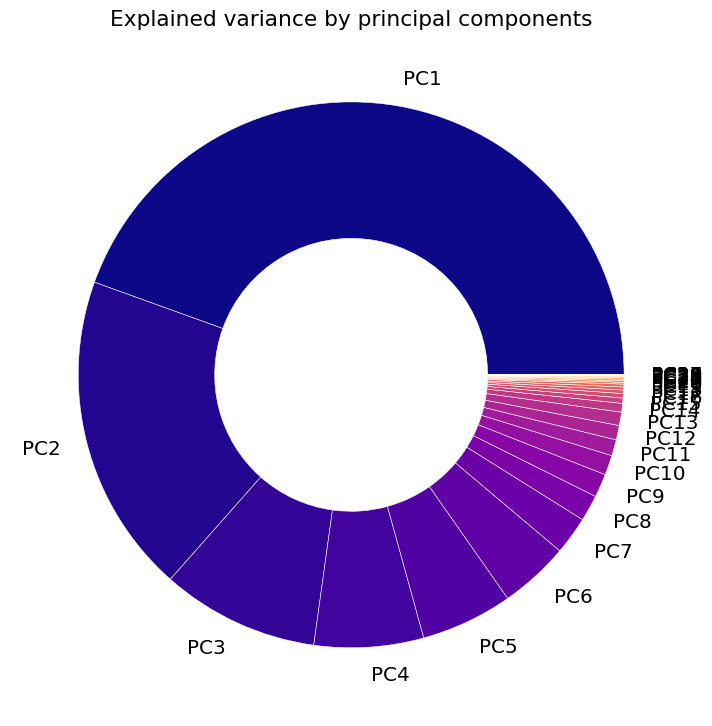

In [11]:
from psynlig import pca_explained_variance_pie
plt.style.use('seaborn-talk')

fig, axi = pca_explained_variance_pie(pca, cmap='plasma')
axi.set_title('Explained variance by principal components')

plt.show()

Hemos calculado los scores para todos los componentes y de acuerdo con el piechart, pareciera que tenemos pocos componentes que explican gran parte de la variación de los datos, pero a simple vista, es dificil identificar cuantos necesitamos para explicar al menos el 70% de la variación, por lo que haremos también el PCA con el paquete pca para ver numéricamente la variaza explicada acumulada:

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [70.0%] explained variance using the [30] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [70.00%] explained variance.
[pca] >The PCA reduction is performed on the [30] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


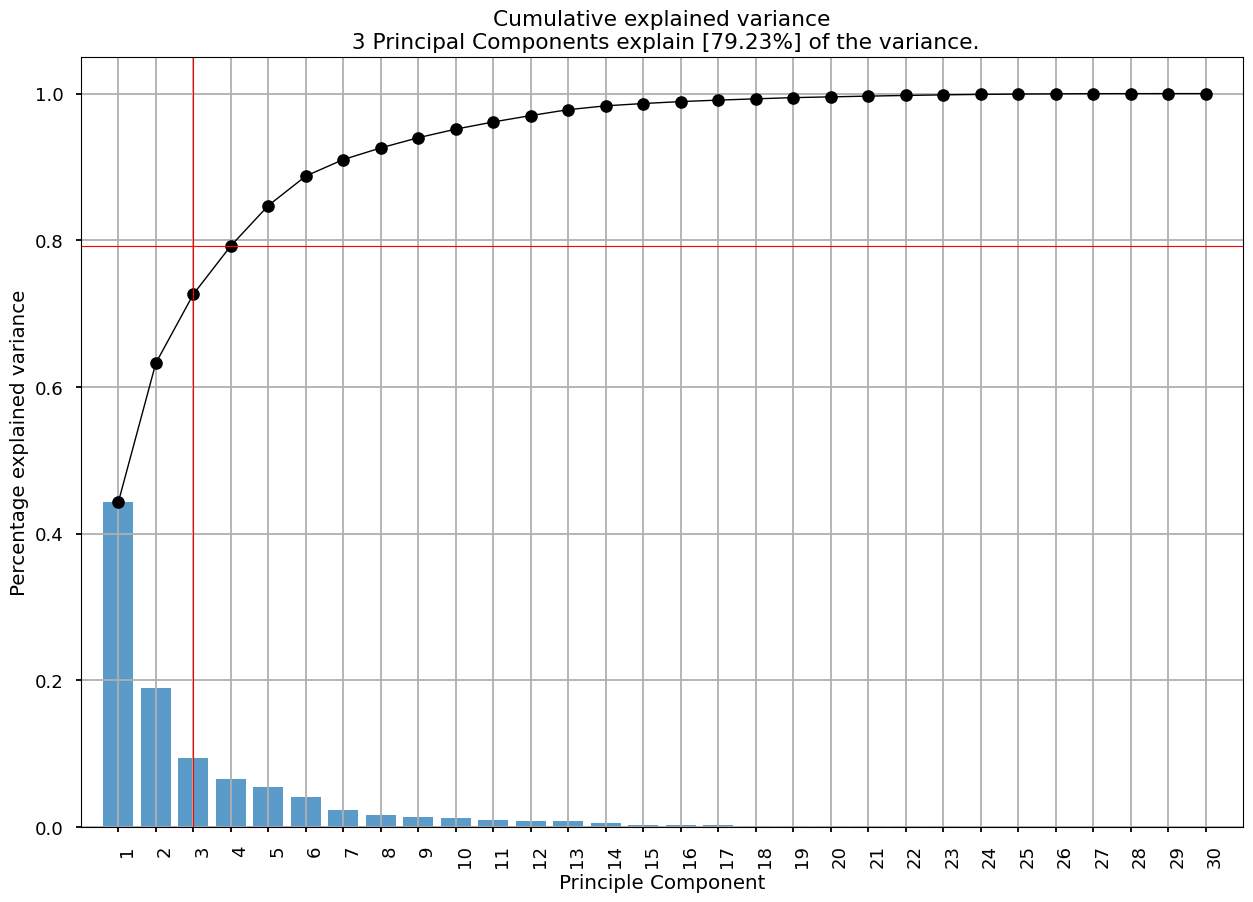

(<Figure size 1500x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 3 Principal Components explain [79.23%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 1040x715 with 0 Axes>

In [12]:
# Vamos a hacer el PCA con el paquete pca:

from pca import pca

# Initialize pca with default parameters
model = pca(normalize=True, n_components=0.7)

# Fit transform
results = model.fit_transform(inputs)

# Plot the explained variance
model.plot()

Como lo estamos viendo en el gráfico, unicamente 3 componentes ya explican el 79% de la variabilidad de los datos, siendo que el mínimo requerido era 70%, estos 3 componentes es justo lo que necesitamos para generar el modelo de regresión. 
Si hablamos del componente 1, este nos explica poco más del 40% de la variabilidad, lo cual es bastante alto (será el principal componente), pero no es suficiente para lo que necesitamos.

In [13]:
model.results['PC']

,PC1,PC2,PC3
842302,9.192837,1.948583,-1.123166
842517,2.387802,-3.768172,-0.529293
84300903,5.733896,-1.075174,-0.551748
84348301,7.122953,10.275589,-3.232789
84358402,3.935302,-1.948072,1.389767
...,...,...,...
926424,6.439315,-3.576817,2.459487
926682,3.793382,-3.584048,2.088476
926954,1.256179,-1.902297,0.562730
927241,10.374794,1.672010,-1.877029


In [14]:
model.results['loadings']

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
PC1,0.218902,0.103725,0.227537,0.220995,0.142590,0.239285,0.258400,0.260854,0.138167,0.064363,...,0.227997,0.104469,0.236640,0.224871,0.127953,0.210096,0.228768,0.250886,0.122905,0.131784
PC2,-0.233857,-0.059706,-0.215181,-0.231077,0.186113,0.151892,0.060165,-0.034768,0.190349,0.366575,...,-0.219866,-0.045467,-0.199878,-0.219352,0.172304,0.143593,0.097964,-0.008257,0.141883,0.275339
PC3,-0.008531,0.064550,-0.009314,0.028700,-0.104292,-0.074092,0.002734,-0.025563,-0.040240,-0.022574,...,-0.047507,-0.042298,-0.048547,-0.011902,-0.259798,-0.236076,-0.173057,-0.170344,-0.271313,-0.232791


En results['PC'] tenemos los resultados de las variables transformadas para cada una de las muestras del set de datos, o sea, este será nuestro nuevo set de datos y sobre el que generaremos el modelo de regresión logística (incluyendo claramente la variable objetivo). 
results['loadings'] nos indica las correlaciones entre las variables originales y los componentes principales con los que trabajaremos. 

Si hablamos del componente principal 1 (PC1), vemos que está correlacionado de forma similar con muchas de las variables orginales, siendo las variables relacionadas a concavidad (Convave points_mean, concavity_mean y concave points_worst) las que tienen más influencia sobre este, mientras que fractal_dimension y texture las que están menos explicadas por este componente. Además, todas están correlacionadas de forma positiva, es decir, que al aumentar el valor de PC1, aumenta el valor de las variables originales. 

Ya podemos unir la variable objetivo y generar el modelo de regresión lineal.

#### c. Crea el input con estas componentes y ajusta un modelo de predicción adecuado para la variable objetivo diagnosis.

In [15]:
n_input = model.results['PC']
n_input

,PC1,PC2,PC3
842302,9.192837,1.948583,-1.123166
842517,2.387802,-3.768172,-0.529293
84300903,5.733896,-1.075174,-0.551748
84348301,7.122953,10.275589,-3.232789
84358402,3.935302,-1.948072,1.389767
...,...,...,...
926424,6.439315,-3.576817,2.459487
926682,3.793382,-3.584048,2.088476
926954,1.256179,-1.902297,0.562730
927241,10.374794,1.672010,-1.877029


In [16]:
# Convertimos la variable objetivo a 0 y 1, donde 0 es B y 1 es M:

n_obj = obj.replace({'B': 0, 'M': 1})
n_obj

id
842302      1
842517      1
84300903    1
84348301    1
84358402    1
           ..
926424      1
926682      1
926954      1
927241      1
92751       0
Name: diagnosis, Length: 569, dtype: int64

In [17]:
# Unimos la variable objetivo a los inputs:

n_wisco = n_input.join(n_obj)
n_wisco.head()

,PC1,PC2,PC3,diagnosis
842302,9.192837,1.948583,-1.123166,1
842517,2.387802,-3.768172,-0.529293,1
84300903,5.733896,-1.075174,-0.551748,1
84348301,7.122953,10.275589,-3.232789,1
84358402,3.935302,-1.948072,1.389767,1


In [18]:
# Generamos el modelo de regresión logística:

from statsmodels.formula.api import logit

formula = 'n_obj ~ n_input'

modelo = sm.formula.logit(formula=formula, data=n_wisco).fit()

modelo.summary()

Optimization terminated successfully.
         Current function value: 0.108409
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  n_obj   No. Observations:                  569
Model:                          Logit   Df Residuals:                      565
Method:                           MLE   Df Model:                            3
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.8358
Time:                        10:53:28   Log-Likelihood:                -61.685
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                8.278e-136
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6762      0.242     -2.796      0.005      -1.150      -0.202
n_input[0]     2.3183      0.304      7.616      0.000       1.722       2.915
n_input[1]    -1.2829      0.212     -6.059      0.000      -1.698      -0.868
n_input[2]    -0.4878      0.141     -3.468      0.001      -0.764      -0.212
==============================================================================

Possibly complete quasi-separation: A fraction 0.27 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

El modelo tiene un pseudo R2 bastante alto, lo cual es bueno, pero lo principal acá para interpretar los coeficientes, será calcular los odd ratio para cada componente, además de la validación cruzada. Haremos esto a continuación.

#### d. Conclusiones del modelo por validación cruzada repetida. Interpreta el parámetro de la componente 1.

In [19]:
# Calculamos los OR para cada componente:

np.exp(modelo.params)

Intercept      0.508541
n_input[0]    10.158264
n_input[1]     0.277231
n_input[2]     0.613948
dtype: float64

In [20]:
# Evaluamos el modelo usando validación cruzada repetida:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
import patsy

formula = 'n_obj ~ n_input'

y, X = patsy.dmatrices(formula, n_wisco, return_type='dataframe')     
y =  y.iloc[:,0].ravel()

model = LogisticRegression()

modelo = sm.formula.logit(formula=formula, data=n_wisco).fit()

cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=1234)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
print('AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Optimization terminated successfully.
         Current function value: 0.108409
         Iterations 10
AUC: 0.991 (0.007)


##### Conclusiones del modelo:

- Estamos logrando un ROC de 0.991 lo cual es muy alto, indicandonos que el modelo tiene una capacidad predictiva bastante buena y se ajusta muy bien a la realidad de los datos. 

- Por otro lado, si analizamos los ORs de cada componente, podemos ver (como era de esperarse) que el primer componente (PC1) es el que más influye en las predicciones, obteniendo un valor de odd ratio de 10.16 para este componente que nos indica que un aumento en el PC1 (que como vimos antes, involucraría un aumento en mayor o menor medida de las variables originales), involucra que la probabilidad de obtener un diagnosis M aumenta en 10.16; por el contrario, los otros componentes, tienen OR menores a 1, por lo que el efecto es inverso: al aumentar el valor de P2 y P3, se reduce la probabilidad en un 72%  y 39% respectivamente (Aprox)